In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import folium
import os
import json
import glob
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from uszipcode import SearchEngine
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

C:\Users\eliel\miniconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Web Scraping para os bairros de San Francisco.

In [2]:
response = requests.get("http://www.healthysf.org/bdi/outcomes/zipmap.htm")

In [3]:
soup = BeautifulSoup(response.text, "lxml")

In [4]:
table = soup.find_all("table")

In [5]:
df = pd.read_html(str(table))
df = pd.DataFrame(df[4])

In [6]:
df.columns = df.iloc[0]

In [7]:
df_sf=df.drop('Population (Census 2000)',axis=1)

In [8]:
df_sf = df_sf.iloc[1:-1]

In [9]:
search = SearchEngine()

latitude = []
longitude = []

for index, row in df_sf.iterrows():
    zipcode = search.by_zipcode(row["Zip Code"]).to_dict()
    latitude.append(zipcode.get("lat"))
    longitude.append(zipcode.get("lng"))

df_sf["Latitude"] = latitude
df_sf["Longitude"] = longitude


In [10]:
address = "San Francisco"

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude,longitude)

37.7790262 -122.419906


In [11]:
# Criando o mapa de São Francisco
map_sf = folium.Map(location = [latitude, longitude], zoom_start=10)
cont=0
for index, row in df_sf.iterrows():
    lat=row['Latitude']
    lng=row['Longitude']
    neigh=row['Neighborhood']
    # add markers to map
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html = True)

    folium.CircleMarker(
            [lat, lng],
            radius = 5,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(map_sf)
map_sf

In [12]:
map_sf.save('SF.html')

In [13]:
tsv_file= r'C:\Users\eliel\Downloads\places-master\places-master\categories\utils\Foursquare_to_NAICS_and_SIC.tsv'

In [14]:
df_codes = pd.read_csv(tsv_file, sep="\t")

In [15]:
#trocar
mask = df_codes["foursquare_category_label"].str.contains("Dining and Drinking")
dining = df_codes[mask].copy()

In [16]:
for index,rows in df_sf.iterrows():
    neigh=rows['Neighborhood']
    lt=rows['Latitude']
    lg=rows['Longitude']
    category_id="13000"
    print(category_id,lt,lg)


    # Imprimir as categorias
    print(
            dining.loc[dining["foursquare_category_label"] == category_id][
                "foursquare_category_label"
            ]
    )
    # Pegando os dados do Foursquare
    url = f"https://api.foursquare.com/v3/places/search?ll={lt},{lg}&radius=500&categories={category_id}&limit=50"
    headers = {
            "Accept": "application/json",
            "Authorization": "fsq3q0iLUn+HVkzbyOHniYOZxGy3OLYuOtMG/8xtsZICemk=",
        }

    response = requests.get(url, headers=headers)
    json_response = response.json()
    #Save os arquivos JSON
    out_file = f"C:\\Users\eliel\OneDrive\Desktop\Project_2\Json\Foursquare_data_{category_id}_{lt}_{lg}.json"
    # Checa se o diretorio existe
    if not os.path.exists(os.path.dirname(out_file)):
            os.makedirs(os.path.dirname(out_file))

    with open(out_file, "w") as f:
        json.dump(json_response, f)

13000 37.78 -122.42
Series([], Name: foursquare_category_label, dtype: object)
13000 37.77 -122.41
Series([], Name: foursquare_category_label, dtype: object)
13000 37.76 -122.39
Series([], Name: foursquare_category_label, dtype: object)
13000 37.79 -122.41
Series([], Name: foursquare_category_label, dtype: object)
13000 37.79 -122.42
Series([], Name: foursquare_category_label, dtype: object)
13000 37.74 -122.41
Series([], Name: foursquare_category_label, dtype: object)
13000 37.72 -122.44
Series([], Name: foursquare_category_label, dtype: object)
13000 37.75 -122.43
Series([], Name: foursquare_category_label, dtype: object)
13000 37.78 -122.43
Series([], Name: foursquare_category_label, dtype: object)
13000 37.74 -122.48
Series([], Name: foursquare_category_label, dtype: object)
13000 37.77 -122.45
Series([], Name: foursquare_category_label, dtype: object)
13000 37.78 -122.46
Series([], Name: foursquare_category_label, dtype: object)
13000 37.77 -122.49
Series([], Name: foursquare_cate


KeyboardInterrupt



In [28]:
list_venues = []
lista=[]
#lenado os arquivo JSON
for index,rows in df_sf.iterrows():
    neigh=rows['Neighborhood']
    lt=rows['Latitude']
    lg=rows['Longitude']
    category_id== "1300"
    for name in glob.glob(f"C:\\Users\eliel\OneDrive\Desktop\Project_2\Json\Foursquare_data_{category_id}_{lt}_{lg}.json"):
        with open(name, "r") as f:
            data = json.load(f)
        df = pd.json_normalize(data["results"])
        for index,rows in df.iterrows():
            cate = rows['categories']
            venue =rows['name']
            venue_latitude=rows['geocodes.main.latitude']
            venue_longitude=rows['geocodes.main.longitude']
            category = cate[0]['name']
            list_venues.append([neigh,lt,lg,venue,venue_latitude,venue_longitude,category])


In [29]:
df_sf_new=pd.DataFrame(list_venues)

In [30]:
#Renomeação das colunas
df_sf_new = df_sf_new.rename(columns={0:'Neighborhood', 1:'Neighborhood Latitude', 2:'Neighborhood Longitude', 3:'Venue', 4:'Venue Latidude', 5:'Venue Longitude', 6:'Venue Category'})

In [31]:
df_sf_new

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latidude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Urban Bowls,37.778034,-122.422409,Poke Restaurant
1,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Whitechapel,37.782334,-122.418720,Cocktail Bar
2,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Philz Coffee,37.781359,-122.416942,"Cafes, Coffee, and Tea Houses"
3,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Robin,37.779307,-122.423272,Asian Restaurant
4,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,Brenda's French Soul Food,37.782806,-122.418963,Cajun / Creole Restaurant
...,...,...,...,...,...,...,...
818,North Beach/Chinatown,37.80,-122.41,Cafe Broadway,37.797867,-122.408239,Cantonese Restaurant
819,North Beach/Chinatown,37.80,-122.41,Mona Lisa Restaurant,37.798458,-122.407772,Italian Restaurant
820,North Beach/Chinatown,37.80,-122.41,Kam PO Kitchen,37.797118,-122.410346,BBQ Joint
821,Visitacion Valley/Sunnydale,37.72,-122.41,Cow Palace,37.719027,-122.409467,Restaurant


In [32]:
#Pesquisar os valores NAN
df_sf_new[df_sf_new['Venue Latidude'].isnull()]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latidude,Venue Longitude,Venue Category
144,Potrero Hill,37.76,-122.39,Tekuno,NaN,NaN,Tea Room
276,Inner Mission/Bernal Heights,37.74,-122.41,Conchita Taco Truck,NaN,NaN,Food Stand
600,Outer Richmond,37.77,-122.49,Rocko's Ice Cream Tacos,NaN,NaN,Food Truck


In [33]:
#ENcontrando a latitude e longitude
lista=[]
for index, rows in df_sf_new[df_sf_new['Venue Latidude'].isnull()].iterrows():
    address=rows['Venue']
    if address == 'Conchita Taco Truck':
        address = address.split()[0]
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lista.append([latitude,longitude])
    else:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lista.append([latitude,longitude])

In [34]:
#Troca os valores NAN pela Latitude e Longitude encontrada
df_sf_new[['Venue Latidude','Venue Longitude']]=df_sf_new[['Venue Latidude','Venue Longitude']].replace(np.nan,str(lista))

In [35]:
#Verificar novamente se existe valores nulos
df_sf_new.isnull().sum()

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latidude            0
Venue Longitude           0
Venue Category            0
dtype: int64

In [36]:
#Verificar quantos locais foram relacionados para cada bairro
df_sf_new.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latidude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview-Hunters Point,14,14,14,14,14,14
Castro/Noe Valley,50,50,50,50,50,50
Chinatown,50,50,50,50,50,50
Haight-Ashbury,50,50,50,50,50,50
Hayes Valley/Tenderloin/North of Market,50,50,50,50,50,50
Ingelside-Excelsior/Crocker-Amazon,50,50,50,50,50,50
Inner Mission/Bernal Heights,50,50,50,50,50,50
Inner Richmond,50,50,50,50,50,50
Lake Merced,37,37,37,37,37,37


In [37]:
# one hot encoding
df_sf_onehot_new = pd.get_dummies(df_sf_new[['Venue Category']], prefix = "", prefix_sep = "")
# Adiciona os bairros em coluna de volta ao dataframe
df_sf_onehot_new['Neighborhood'] = df_sf_new['Neighborhood']

#Reodernando as colunas
df_sf_onehot_new = df_sf_onehot_new.reindex(columns=['Neighborhood','African Restaurant', 'American Restaurant', 'Arcade','Arts and Entertainment', 'Asian Restaurant', 'Australian Restaurant',
       'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bar', 'Beer Bar', 'Bistro',
       'Breakfast Spot', 'Brewery', 'Bubble Tea Shop', 'Buffet',
       'Burger Joint', 'Burmese Restaurant', 'Cafes, Coffee, and Tea Houses',
       'Café', 'Cajun / Creole Restaurant', 'Cantonese Restaurant',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Cocktail Bar',
       'Coffee Shop', 'Concert Hall', 'Creperie', 'Deli', 'Dessert Shop',
       'Dim Sum Restaurant', 'Diner', 'Dining and Drinking', 'Dive Bar',
       'Donut Shop', 'Falafel Restaurant', 'Fast Food Restaurant','Filipino Restaurant', 'Food Stand', 'Food Truck', 'French Restaurant',
       'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Gay Bar',
       'Greek Restaurant', 'Halal Restaurant', 'Hookah Bar', 'Hot Dog Joint',
       'Ice Cream Parlor', 'Indian Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Jazz and Blues Venue', 'Juice Bar',
       'Karaoke Bar', 'Kebab Restaurant', 'Korean Restaurant',
       'Latin American Restaurant', 'Lebanese Restaurant', 'Lounge', 'Meadery',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'Movie Theater', 'Music Venue',
       'New American Restaurant', 'Night Club', 'North Indian Restaurant',
       'Pastry Shop', 'Peruvian Restaurant', 'Pizzeria', 'Poke Restaurant', 'Pool Hall', 'Pub', 'Ramen Restaurant', 'Restaurant', 'Rock Club',
       'Russian Restaurant', 'Sandwich Restaurant', 'Seafood Restaurant',
       'Snack Place', 'Speakeasy', 'Sports Bar', 'Steakhouse',
       'Sushi Restaurant', 'Szechuan Restaurant', 'Taco Restaurant',
       'Taiwanese Restaurant', 'Tapas Restaurant', 'Tea Room',
       'Thai Restaurant', 'Vegan and Vegetarian Restaurant',
       'Vietnamese Restaurant', 'Vineyard', 'Whisky Bar', 'Wine Bar', 'Winery' ])


In [38]:
df_sf_onehot_new.shape

(823, 99)

In [39]:
#Agrupar as linhas por bairro e tomando a média da frequência de ocorrência de cada categoria
df_sf_grouped = df_sf_onehot_new.groupby('Neighborhood').mean().reset_index()
df_sf_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arcade,Arts and Entertainment,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Winery
0,Bayview-Hunters Point,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
1,Castro/Noe Valley,0.0,0.04,0.0,0.0,0.00,0.02,0.02,0.04,0.10,...,0.0,0.00,0.0,0.00,0.02,0.00,0.0,0.0,0.00,0.0
2,Chinatown,0.0,0.06,0.0,0.0,0.02,0.00,0.00,0.02,0.02,...,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.02,0.0
3,Haight-Ashbury,0.0,0.02,0.0,0.0,0.02,0.00,0.00,0.00,0.02,...,0.0,0.00,0.0,0.04,0.00,0.02,0.0,0.0,0.02,0.0
4,Hayes Valley/Tenderloin/North of Market,0.0,0.02,0.0,0.0,0.10,0.00,0.00,0.00,0.02,...,0.0,0.02,0.0,0.04,0.02,0.02,0.0,0.0,0.02,0.0


In [40]:
# função para classificar os locais em ordem decrescente.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
#criar um novo dataframe e exibir os 10 melhores locais para cada bairro.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        # append 'st', 'nd', 'rd' to the top 3 venues
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = df_sf_grouped['Neighborhood']

for ind in np.arange(df_sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview-Hunters Point,Restaurant,Coffee Shop,Bar,Meadery,Dining and Drinking,Dessert Shop,Chinese Restaurant,Juice Bar,Tea Room,Middle Eastern Restaurant
1,Castro/Noe Valley,Restaurant,Burger Joint,Bakery,Pizzeria,Mexican Restaurant,Coffee Shop,Sports Bar,Sushi Restaurant,American Restaurant,Ice Cream Parlor
2,Chinatown,Restaurant,Cocktail Bar,Café,Korean Restaurant,American Restaurant,Bubble Tea Shop,Coffee Shop,Sushi Restaurant,Pizzeria,Burger Joint
3,Haight-Ashbury,Café,Coffee Shop,Cocktail Bar,Thai Restaurant,Pub,Fast Food Restaurant,Restaurant,Dive Bar,Caribbean Restaurant,Ice Cream Parlor
4,Hayes Valley/Tenderloin/North of Market,Cocktail Bar,Asian Restaurant,Coffee Shop,Café,"Cafes, Coffee, and Tea Houses",Restaurant,Sandwich Restaurant,Burger Joint,Thai Restaurant,Greek Restaurant


## Machine Learning

In [42]:
df_sf_grouped_clustering = df_sf_grouped.drop('Neighborhood', 1)

C:\Users\eliel\AppData\Local\Temp\ipykernel_8496\3331676409.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_sf_grouped_clustering = df_sf_grouped.drop('Neighborhood', 1)


In [43]:
#Metodo do cotovelo
sum=[]

k=range(2,12)
for i in k:
    kmeans=KMeans(n_clusters=i).fit(df_sf_grouped_clustering)
    sum.append(kmeans.inertia_)


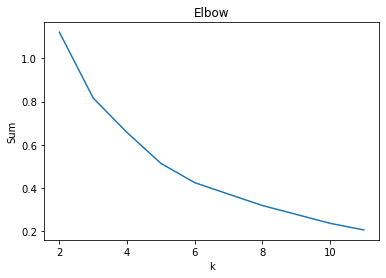

In [44]:
plt.plot(k,sum)
plt.xlabel('k')
plt.ylabel('Sum')
plt.title('Elbow')
plt.show()

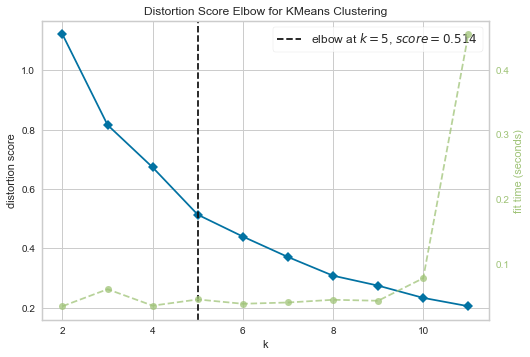

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
yellow_visualizer = KElbowVisualizer(kmeans, k=(2,12))
yellow_visualizer.fit(df_sf_grouped_clustering)
yellow_visualizer.show()

In [48]:
from sklearn.cluster import KMeans
# O melhor número de clusters
kclusters = 5
# Usar o K means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df_sf_grouped_clustering)
# Checa o label cluster gerados para cada linha no dataframe
kmeans.labels_[0:10]

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [49]:
# Adiciona os rotulos dos clustering
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [50]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Bayview-Hunters Point,Restaurant,Coffee Shop,Bar,Meadery,Dining and Drinking,Dessert Shop,Chinese Restaurant,Juice Bar,Tea Room,Middle Eastern Restaurant
1,4,Castro/Noe Valley,Restaurant,Burger Joint,Bakery,Pizzeria,Mexican Restaurant,Coffee Shop,Sports Bar,Sushi Restaurant,American Restaurant,Ice Cream Parlor
2,4,Chinatown,Restaurant,Cocktail Bar,Café,Korean Restaurant,American Restaurant,Bubble Tea Shop,Coffee Shop,Sushi Restaurant,Pizzeria,Burger Joint
3,4,Haight-Ashbury,Café,Coffee Shop,Cocktail Bar,Thai Restaurant,Pub,Fast Food Restaurant,Restaurant,Dive Bar,Caribbean Restaurant,Ice Cream Parlor
4,4,Hayes Valley/Tenderloin/North of Market,Cocktail Bar,Asian Restaurant,Coffee Shop,Café,"Cafes, Coffee, and Tea Houses",Restaurant,Sandwich Restaurant,Burger Joint,Thai Restaurant,Greek Restaurant
5,4,Ingelside-Excelsior/Crocker-Amazon,Latin American Restaurant,Asian Restaurant,Pizzeria,Bakery,Chinese Restaurant,Café,Fast Food Restaurant,BBQ Joint,American Restaurant,Vietnamese Restaurant
6,4,Inner Mission/Bernal Heights,Restaurant,Bakery,American Restaurant,Pizzeria,Fast Food Restaurant,Food Truck,Winery,Juice Bar,Latin American Restaurant,Night Club
7,4,Inner Richmond,Vietnamese Restaurant,Pizzeria,Restaurant,Cocktail Bar,Chinese Restaurant,Burger Joint,Deli,Fast Food Restaurant,American Restaurant,Thai Restaurant
8,4,Lake Merced,Restaurant,Pizzeria,Sandwich Restaurant,Café,Burger Joint,Bagel Shop,American Restaurant,Halal Restaurant,Coffee Shop,Cocktail Bar
9,4,Marina,Restaurant,Cocktail Bar,Burger Joint,American Restaurant,Bar,Deli,Mexican Restaurant,Ramen Restaurant,Dive Bar,Coffee Shop


In [51]:
df_sf_merged = df_sf

#JUnta os dataframes
df_sf_merged = df_sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_sf_merged.head()

,Zip Code,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,94102,Hayes Valley/Tenderloin/North of Market,37.78,-122.42,4,Cocktail Bar,Asian Restaurant,Coffee Shop,Café,"Cafes, Coffee, and Tea Houses",Restaurant,Sandwich Restaurant,Burger Joint,Thai Restaurant,Greek Restaurant
2,94103,South of Market,37.77,-122.41,4,Night Club,Coffee Shop,Dining and Drinking,Gay Bar,Café,Restaurant,Japanese Restaurant,Chinese Restaurant,Food Truck,Mexican Restaurant
3,94107,Potrero Hill,37.76,-122.39,4,Cocktail Bar,Bakery,Wine Bar,Ice Cream Parlor,Dessert Shop,Bar,Pizzeria,American Restaurant,BBQ Joint,Bubble Tea Shop
4,94108,Chinatown,37.79,-122.41,4,Restaurant,Cocktail Bar,Café,Korean Restaurant,American Restaurant,Bubble Tea Shop,Coffee Shop,Sushi Restaurant,Pizzeria,Burger Joint
5,94109,Polk/Russian Hill (Nob Hill),37.79,-122.42,4,Cocktail Bar,Coffee Shop,Asian Restaurant,Night Club,Bakery,Bar,Deli,Burger Joint,Diner,Café


In [52]:
# Cria o mapa de SF com cluster
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

# definir as cores para os clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add ao clurtes no mapa
markers_colors = []
for lat, lon, poi, cluster in zip(df_sf_merged['Latitude'], df_sf_merged['Longitude'], df_sf_merged['Neighborhood'], df_sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)

map_clusters

In [53]:
map_clusters.save('SF_cluster.html')

In [54]:
df_sf_new.to_csv('SF.csv')

In [55]:
df_total_new_sf=pd.read_csv('SF.csv')

#### Examine Clusters

In [56]:
#1
df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 0, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Parkside/Forest Hill,Chinese Restaurant,Asian Restaurant,Café,Deli,Bubble Tea Shop,American Restaurant,Pizzeria,Restaurant,Cocktail Bar,Cantonese Restaurant
14,Sunset,Asian Restaurant,Bakery,Bubble Tea Shop,Deli,Restaurant,Coffee Shop,Szechuan Restaurant,Cocktail Bar,Chinese Restaurant,BBQ Joint
18,Twin Peaks-Glen Park,Chinese Restaurant,Bakery,Burger Joint,Restaurant,Coffee Shop,Cantonese Restaurant,Café,Sushi Restaurant,African Restaurant,Poke Restaurant


In [59]:
df_k1=df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 0, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]
df_k1=df_k1.drop('Neighborhood',axis=1)

In [60]:
for col in df_k1:
    #print(df_k1[col])
    print(df_k1[col].value_counts(ascending= False))
    print("---------------------------------")

Chinese Restaurant    2
Asian Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------
Bakery              2
Asian Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------
Café               1
Bubble Tea Shop    1
Burger Joint       1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------
Deli          2
Restaurant    1
Name: 4th Most Common Venue, dtype: int64
---------------------------------
Bubble Tea Shop    1
Restaurant         1
Coffee Shop        1
Name: 5th Most Common Venue, dtype: int64
---------------------------------
American Restaurant     1
Coffee Shop             1
Cantonese Restaurant    1
Name: 6th Most Common Venue, dtype: int64
---------------------------------
Pizzeria               1
Szechuan Restaurant    1
Café                   1
Name: 7th Most Common Venue, dtype: int64
---------------------------------
Restaurant          1
Cocktail Bar        1
Sushi Restaurant    1

In [61]:
#2
df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 1, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Visitacion Valley/Sunnydale,Restaurant,Arts and Entertainment,African Restaurant,Mexican Restaurant,Pizzeria,Peruvian Restaurant,Pastry Shop,North Indian Restaurant,Night Club,New American Restaurant


In [62]:
#3
df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 2, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Outer Richmond,Food Truck,Pizzeria,BBQ Joint,Mediterranean Restaurant,Peruvian Restaurant,Pastry Shop,North Indian Restaurant,Night Club,New American Restaurant,Music Venue


In [63]:
#4
df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 3, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Bayview-Hunters Point,Restaurant,Coffee Shop,Bar,Meadery,Dining and Drinking,Dessert Shop,Chinese Restaurant,Juice Bar,Tea Room,Middle Eastern Restaurant


In [64]:
#5
df_sf_merged.loc[df_sf_merged['Cluster Labels'] == 4, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Hayes Valley/Tenderloin/North of Market,Cocktail Bar,Asian Restaurant,Coffee Shop,Café,"Cafes, Coffee, and Tea Houses",Restaurant,Sandwich Restaurant,Burger Joint,Thai Restaurant,Greek Restaurant
2,South of Market,Night Club,Coffee Shop,Dining and Drinking,Gay Bar,Café,Restaurant,Japanese Restaurant,Chinese Restaurant,Food Truck,Mexican Restaurant
3,Potrero Hill,Cocktail Bar,Bakery,Wine Bar,Ice Cream Parlor,Dessert Shop,Bar,Pizzeria,American Restaurant,BBQ Joint,Bubble Tea Shop
4,Chinatown,Restaurant,Cocktail Bar,Café,Korean Restaurant,American Restaurant,Bubble Tea Shop,Coffee Shop,Sushi Restaurant,Pizzeria,Burger Joint
5,Polk/Russian Hill (Nob Hill),Cocktail Bar,Coffee Shop,Asian Restaurant,Night Club,Bakery,Bar,Deli,Burger Joint,Diner,Café
6,Inner Mission/Bernal Heights,Restaurant,Bakery,American Restaurant,Pizzeria,Fast Food Restaurant,Food Truck,Winery,Juice Bar,Latin American Restaurant,Night Club
7,Ingelside-Excelsior/Crocker-Amazon,Latin American Restaurant,Asian Restaurant,Pizzeria,Bakery,Chinese Restaurant,Café,Fast Food Restaurant,BBQ Joint,American Restaurant,Vietnamese Restaurant
8,Castro/Noe Valley,Restaurant,Burger Joint,Bakery,Pizzeria,Mexican Restaurant,Coffee Shop,Sports Bar,Sushi Restaurant,American Restaurant,Ice Cream Parlor
9,Western Addition/Japantown,Fast Food Restaurant,Coffee Shop,Night Club,American Restaurant,Café,Asian Restaurant,Pizzeria,Burger Joint,Karaoke Bar,Italian Restaurant
11,Haight-Ashbury,Café,Coffee Shop,Cocktail Bar,Thai Restaurant,Pub,Fast Food Restaurant,Restaurant,Dive Bar,Caribbean Restaurant,Ice Cream Parlor


In [70]:
df_k5 = df_sf_merged.loc[
    df_sf_merged['Cluster Labels'] == 4, df_sf_merged.columns[[1] + list(range(5, df_sf_merged.shape[1]))]]
df_k5 = df_k5.drop('Neighborhood', axis=1)

In [71]:
for col in df_k5:
    #print(df_k1[col])
    print(df_k5[col].value_counts(ascending=False))
    print("---------")

Restaurant                   5
Cocktail Bar                 4
Night Club                   1
Latin American Restaurant    1
Fast Food Restaurant         1
Café                         1
Vietnamese Restaurant        1
Thai Restaurant              1
Name: 1st Most Common Venue, dtype: int64
---------
Coffee Shop           4
Asian Restaurant      2
Bakery                2
Cocktail Bar          2
Pizzeria              2
Burger Joint          1
Chinese Restaurant    1
Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------
Bakery                 2
Restaurant             2
Coffee Shop            1
Dining and Drinking    1
Wine Bar               1
Café                   1
Asian Restaurant       1
American Restaurant    1
Pizzeria               1
Night Club             1
Cocktail Bar           1
Burger Joint           1
Sandwich Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
---------
Pizzeria               3
Café                   2
American Restaurant    2
Gay 